In [1]:
from models.vae_nohist_glm2 import VAE_NoHist_GLM2, NN_Encoder


import numpy as np
import torch
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt

In [2]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"

E_neural_file = "Espikes_neural.npy"
I_neural_file = "Ispikes_neural.npy"
V_file = "V_diff.npy"
C_syn_e_file = "handsub5_C_syn_e.npy"
C_syn_i_file = "handsub5_C_syn_i.npy"
C_den_file = "handsub5_C_den.npy"

E_neural = np.load(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = np.load(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)
C_syn_e = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_syn_e_file)
C_syn_i = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_syn_i_file)
C_den = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_den_file)

E_neural = torch.from_numpy(E_neural)
I_neural = torch.from_numpy(I_neural)
C_syn_e = torch.from_numpy(C_syn_e)
C_syn_i = torch.from_numpy(C_syn_i)
V = torch.from_numpy(V)
C_den = torch.from_numpy(C_den)
sub_no = C_den.shape[0]
V[V < 0.3] = 0

In [3]:
T_train = 8 * 1000 * 50
T_test = 1 * 1000 * 50
T_no = 401
save_dir = base_dir+cell_type+"_"+experiment+"/"
device = torch.device("cuda")

batch_size = 50000
iter_no = 10000
epoch_no = 3000
layer_no = 3

In [4]:
V_train = V[:T_train].float()
V_test = V[T_train:T_train + T_test].to(device).float()
test_E_neural = E_neural[T_train:T_train+T_test].float().to(device)
test_I_neural = I_neural[T_train:T_train+T_test].float().to(device)
train_E_neural = E_neural[:T_train].float()
train_I_neural = I_neural[:T_train].float()
C_syn_e = C_syn_e.float().to(device)
C_syn_i = C_syn_i.float().to(device)
C_den = C_den.float().to(device)

batch_no = (T_train - batch_size) * epoch_no
train_idx = np.empty((epoch_no, T_train//batch_size))
for i in range(epoch_no):
    #part_idx = np.arange(T_train - batch_size)
    part_idx = np.arange(0, T_train, batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [5]:
decoder = VAE_NoHist_GLM2(C_den, C_syn_e, C_syn_i, T_no, device)
encoder = NN_Encoder(C_syn_e, C_syn_i, T_no, layer_no, device)

enc_optimizer = torch.optim.Adam(encoder.parameters(), lr = 0.0001)
dec_optimizer = torch.optim.Adam(decoder.parameters(), lr = 0.005)

encoder.to(device).float()
decoder.to(device).float()
print(sum(p.numel() for p in encoder.parameters() if p.requires_grad))
print(sum(p.numel() for p in decoder.parameters() if p.requires_grad))

bce_criterion = nn.BCELoss(reduction="none")

12267
92


In [6]:
Z_prior = torch.ones(batch_size).to(device) * 0.001
loss_factor = 1
temp_list = [0.5,0.4,0.3,0.2,0.1,0.09,0.08,0.07,0.06,0.05,0.04,0.03,0.02,0.01]
temp_count = 0

true = np.load("/media/hdd01/sklee/CA1_clust4-60/data/vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep10_stimseed1.npy")[:,:50000].flatten()[T_train:T_train+T_test]
old = np.load("/media/hdd01/sklee/CA1_clust4-60/alpha_sub6_output.npz")["test"]

old_score = metrics.explained_variance_score(y_true=true, y_pred=old)

for i in tnrange(iter_no):
    encoder.train()
    decoder.train()
    enc_optimizer.zero_grad()
    dec_optimizer.zero_grad()
    
    #if (i%500==0) & (temp_count < 14):
        #temp = temp_list[temp_count]
        #temp_count += 1
        
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_size].to(device)
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_size].to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_size].to(device)
    
    spk_enc, Z_enc = encoder(batch_V, batch_E_neural, batch_I_neural)
    
    V_pred, Z_pred, out_filters = decoder.train_forward(batch_E_neural, batch_I_neural, spk_enc)

    prior_loss = torch.mean(bce_criterion(Z_enc , Z_prior))
    bern_loss = torch.mean( bce_criterion(Z_pred, Z_enc.detach()))
    var_loss = torch.var(batch_V - V_pred)    
    #var_loss = torch.mean((batch_V - V_pred)**2)
    
    loss_var_exp = metrics.explained_variance_score(y_true=batch_V.cpu().detach().numpy(),
                                                      y_pred=V_pred.cpu().detach().numpy())
        
    loss = var_loss + bern_loss + prior_loss
    loss.backward()
    enc_optimizer.step()
    dec_optimizer.step()
    
    if i%250 == 249:
        test_V_pred, test_Z_pred, test_out_filters = decoder.test_forward(test_E_neural, test_I_neural)
        test_spk_enc, test_Z_enc = encoder(V_test, test_E_neural, test_I_neural)
         
        test_bern_loss = torch.mean(bce_criterion(test_Z_pred, test_Z_enc.detach()))
        
        new_score = metrics.explained_variance_score(y_true=V_test.cpu().detach().numpy(),
                                                      y_pred=test_V_pred.cpu().detach().numpy())

        
        print(i, new_score, loss_var_exp, test_bern_loss.item(), torch.sum(test_spk_enc).item())


<ipython-input-6-569987787638>:11: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


249 -1.0565829277038574 0.08681470155715942 0.02818169631063938 86.27992248535156
499 -0.34694480895996094 0.6202638149261475 0.023731818422675133 169.89376831054688
749 -0.207159161567688 0.6181465983390808 0.01892700418829918 135.340576171875
999 -0.12506401538848877 0.6511949300765991 0.022153183817863464 163.52658081054688
1249 -0.16321635246276855 0.5863792896270752 0.020832916721701622 135.1400146484375
1499 -0.1549443006515503 0.5925078392028809 0.02387714385986328 181.81396484375
1749 -0.16186630725860596 0.6492613554000854 0.025820432230830193 195.38145446777344
1999 -0.16330194473266602 0.6454221606254578 0.020934566855430603 147.78091430664062
2249 -0.18253159523010254 0.6708638668060303 0.026703227311372757 193.29092407226562
2499 -0.14997661113739014 0.5991353988647461 0.02088218368589878 157.46615600585938
2749 -0.16622662544250488 0.6094162464141846 0.022595960646867752 181.1207275390625
2999 -0.1565631628036499 0.7458969354629517 0.020659858360886574 144.6530303955078
3

Parameter containing:
tensor([-0.2198], device='cuda:0', requires_grad=True) Parameter containing:
tensor([2.0924], device='cuda:0', requires_grad=True)


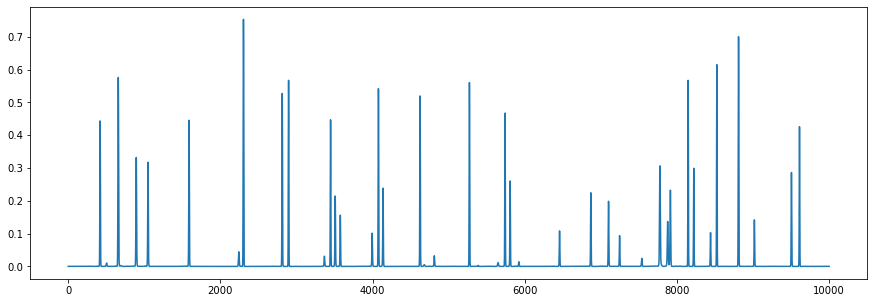

In [7]:
plt.figure(figsize=(15,5))
plt.plot(test_Z_enc.cpu().detach().numpy()[16000:26000])
print(decoder.W_spk, decoder.Tau_spk)

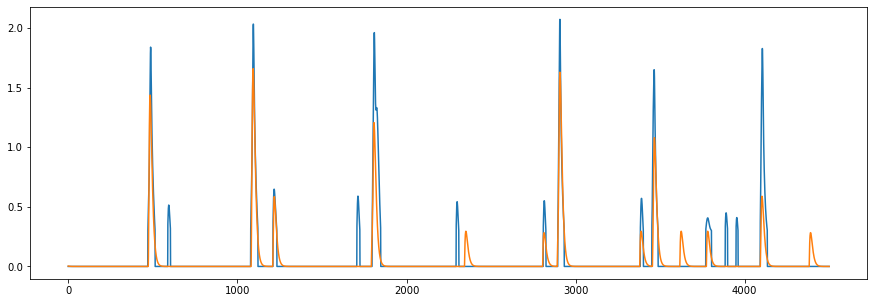

In [8]:
plt.figure(figsize=(15,5))
plt.plot(batch_V.cpu().detach().numpy()[16000:26000][:4500])
plt.plot(V_pred.cpu().detach().numpy()[16000:26000][:4500])


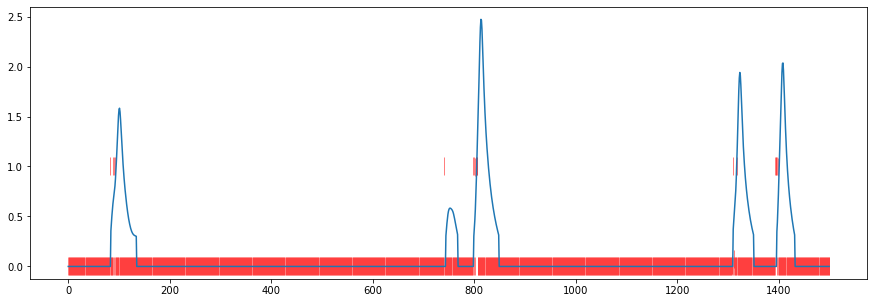

In [9]:
plt.figure(figsize=(15,5))
#print(test_spk_enc.cpu().detach().numpy()[16000:26000][1000:2000][100:150])

plt.plot(V_test.cpu().detach().numpy()[16000:26000][1500:3000])
plt.scatter(np.arange(1500),test_spk_enc.cpu().detach().numpy()[16000:26000][1500:3000], marker="|", s=300, linewidth=0.5, c="red")


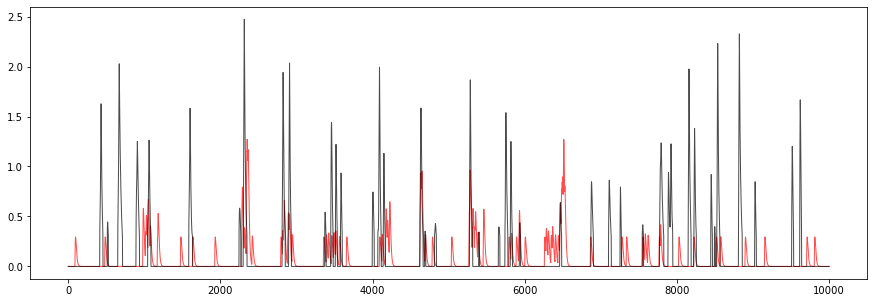

In [10]:
plt.figure(figsize=(15,5))
plt.plot(test_V_pred.cpu().detach().numpy()[16000:26000], c="red", alpha=0.7, linewidth=1)
plt.plot(V_test.cpu().detach().numpy()[16000:26000], c="black", alpha=0.7, linewidth=1)


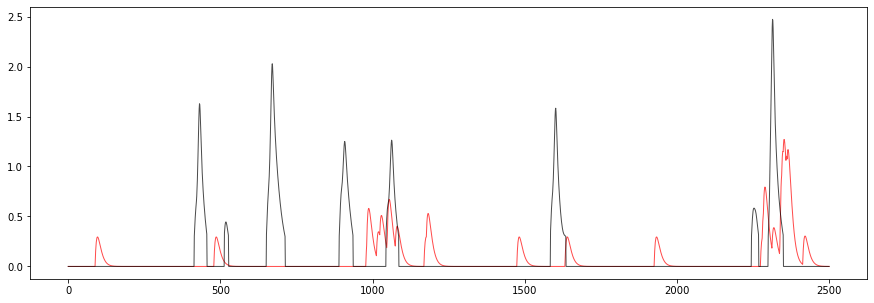

In [11]:
plt.figure(figsize=(15,5))
plt.plot(test_V_pred.cpu().detach().numpy()[16000:26000][:2500], c="red", alpha=0.7, linewidth=1)
plt.plot(V_test.cpu().detach().numpy()[16000:26000][:2500], c="black", alpha=0.7, linewidth=1)


In [12]:
for name, param in decoder.named_parameters():
    if param.requires_grad:
        print(name, param.data)

W_syn tensor([[ 6.3959e-03, -1.3226e-02],
        [ 1.6602e-03,  5.2884e-03],
        [ 1.1053e+00,  3.6396e-03],
        [ 7.8975e-01,  5.3149e-03],
        [ 1.1867e+00,  4.6912e-03],
        [ 1.9326e+00, -2.1593e-03],
        [-1.1879e+00, -2.2236e-03],
        [-5.5464e-01,  1.3067e-02],
        [ 8.6967e-01,  3.6188e-03],
        [ 7.1476e-01, -6.3712e-03]], device='cuda:0')
Tau_syn tensor([[1.0000, 1.0000],
        [1.0000, 1.0000],
        [3.6541, 1.0000],
        [1.3689, 1.0000],
        [8.8607, 1.0000],
        [2.2100, 1.0000],
        [1.4720, 1.0000],
        [7.1035, 1.0000],
        [6.2827, 1.0000],
        [2.6058, 1.0000]], device='cuda:0')
Delta_syn tensor([[ 1.0000,  1.0000],
        [ 1.0000,  1.0000],
        [ 2.7665,  1.0000],
        [-1.0064,  1.0000],
        [ 4.4107,  1.0000],
        [ 8.7580,  1.0000],
        [-1.2133,  1.0000],
        [ 4.9115,  1.0000],
        [ 2.8219,  1.0000],
        [-0.4414,  1.0000]], device='cuda:0')
W_plex tensor([[-1.686